In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare the data

In [2]:
coarse_factors = [32]
Directory = f"data"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

model_number = 11
tmin=1
tmax=62+1

### Split train test ds

In [3]:
path_times_train = f'data/test_train_times/times_train_{model_number}.csv'
path_times_test = f'data/test_train_times/times_test_{model_number}.csv'
isFile = os.path.isfile(path_times_train) and os.path.isfile(path_times_test)

if not isFile :
    utils.split_times(tmin,tmax,model_number)
    
train_times = pd.read_csv(path_times_train).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(path_times_test).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]

In [4]:
input_train, output_train, input_test, output_test = utils.make_train_test_ds(coarse_factors, len_in, train_times, test_times, Directory)

### Normalize the data

In [5]:
ins = [input_train, input_test]
outs = [output_train, output_test]

for input in ins:
    input = input.reshape(-1,len(variables)-1,nz)
    for i in range(len(variables)-1):
        input[:,i] -= input[:,i].mean()
        input[:,i] /= input[:,i].std()
    input = input.reshape(-1,(len(variables)-1)*nz)

for output in outs:
    output -= output.mean()
    output /= output.std()

## Define the model

In [25]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.2, drop_prob2=0.3, drop_prob3=0.4, hidden_size1=1024, hidden_size2=512, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.BatchNorm1d(input_size, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True),
                                        nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size1, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size2, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size3, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

## Train and test the model

In [27]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size = 32             # obligé de le mettre à 16 si pls car sinon le nombre total de samples n'est pas divisible par batch_size 
nb_epochs = [300, 300, 300, 300]   # et on ne peut donc pas reshape. Sinon il ne pas prendre certains samples pour que ça tombe juste.
train_losses=[]
test_losses=[]
models=[]
n_batches = input_train.shape[0]//batch_size

for i in range(len(learning_rates)):
    model = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates[i])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.985, last_epoch= -1)
    models.append(model)
    train_losses_i = []
    test_losses_i = []
    for epoch in trange(nb_epochs[i], leave=False):
        model.train()
        tot_losses=0
        indexes_arr = np.random.permutation(input_train.shape[0]).reshape(-1, batch_size)
        for i_batch in indexes_arr:
            input_batch = input_train[i_batch,:]
            output_batch = output_train[i_batch,:]
            optimizer.zero_grad()
            # forward pass
            output_pred = model(input_batch)
            # compute loss
            loss = F.mse_loss(output_pred, output_batch, reduction='mean')
            tot_losses += loss.item()
            # backward pass
            loss.backward()
            optimizer.step()
        train_losses_i.append(tot_losses/n_batches)     # loss moyenne sur tous les batchs 
        #print(tot_losses)                               # comme on a des batch 2 fois plus petit (16 au lieu de 32)
        model.eval()                                    # on a une loss en moyenne 2 fois plus petite
        # prediction
        output_pred = model(input_test)
        # compute loss
        test_loss = F.mse_loss(output_pred, output_test, reduction='mean')
        test_losses_i.append(test_loss.item())

        if epoch < 200:
            scheduler.step()

    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)
    print('Model {},Epoch [{}/{}], Loss: {:.6f}'.format(i+1,epoch+1, nb_epochs[i], tot_losses/n_batches))

Model 1,Epoch [300/300], Loss: 0.080234


Model 2,Epoch [300/300], Loss: 0.080386


Model 3,Epoch [300/300], Loss: 0.091964


Model 4,Epoch [300/300], Loss: 0.155343


## Plots

Text(0.5, 1.0, 'loss with exponential decaying loss (initial lr = 0.0001, gamma = 0.99)')

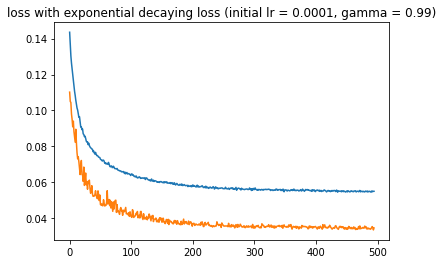

In [22]:
plt.plot(train_losses[0][5:])
plt.plot(test_losses[0][5:])
plt.title(f"loss with exponential decaying loss (initial lr = {learning_rates[0]}, gamma = 0.99)")

Text(0.5, 1.0, 'loss with learning rate = 1e-05')

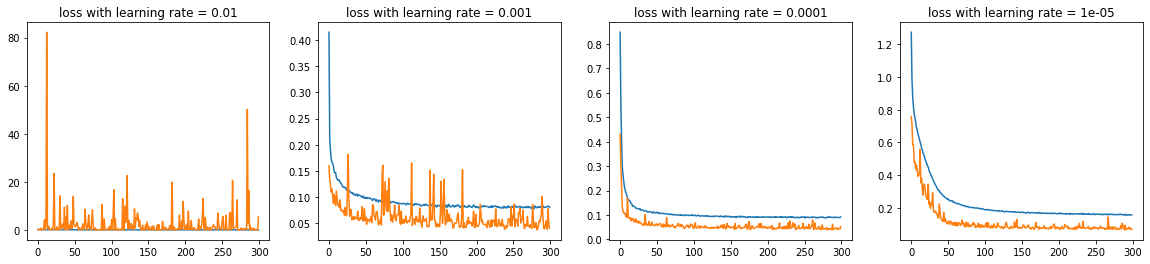

In [30]:
fig,axes = plt.subplots(1,4,figsize=(20,4))

axes[0].plot(train_losses[0][:])
axes[1].plot(train_losses[1][:])
axes[2].plot(train_losses[2][:])
axes[3].plot(train_losses[3][:])

axes[0].plot(test_losses[0][:])
axes[1].plot(test_losses[1][:])
axes[2].plot(test_losses[2][:])
axes[3].plot(test_losses[3][:])

axes[0].set_title(f"loss with learning rate = {learning_rates[0]}")
axes[1].set_title(f"loss with learning rate = {learning_rates[1]}")
axes[2].set_title(f"loss with learning rate = {learning_rates[2]}")
axes[3].set_title(f"loss with learning rate = {learning_rates[3]}")

In [23]:
torch.save(models[0].state_dict(), f'explo/simple_dnn11')